rawないよ
200
{'名古屋（愛知県)': {'2023-12-1': {'合計降水量': '0.0',
                            '合計降雪': '--',
                            '天気概況（夜）': '曇時々晴',
                            '天気概況（昼）': '晴時々曇',
                            '平均気温': '7.9',
                            '平均湿度': '67',
                            '平均風速': '2.2',
                            '日照時間': '5.2',
                            '最低気温': '4.1',
                            '最大10分間降水量': '0.0',
                            '最大1時間降水量': '0.0',
                            '最大瞬間風速': '7.5',
                            '最大瞬間風速（風向）': '西北西',
                            '最大風速': '4.6',
                            '最大風速（風向）': '北',
                            '最小湿度': '47',
                            '最深積雪': '--',
                            '最高気温': '12.5',
                            '海面気圧（平均）': '1017.7',
                            '現地気圧（平均）': '1010.8'},
              '2023-12-10': {'合計降水量': '--',
                             '合計降雪': '--',
  

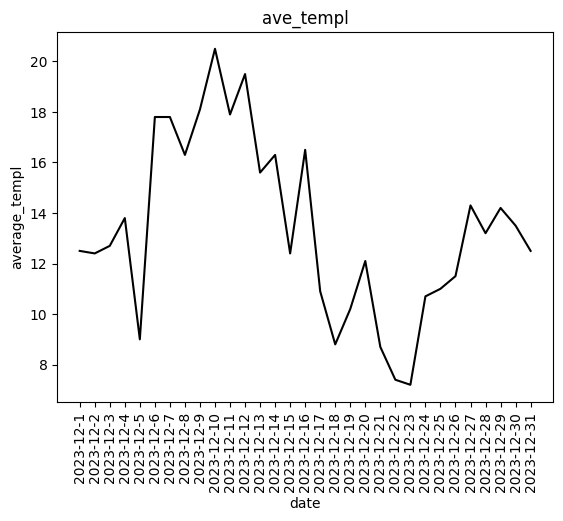

In [3]:
import requests
import json
import os
import csv
import pprint
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from db_create import table_create

def check_exist_file(filepath:str)->bool:
    p1 = pathlib.Path(filepath)
    return p1.exists()

def chimei_replace(chimei_keys):
    return chimei_keys.split('（')[0] #リスト化してくれた
# ある規則に従って、切り分けてリスト化してくれるのが、split 関数

url_kako = "https://api.cultivationdata.net/past"

number = 47636
year=2023
month =12

# number = int(input("国際地点番号を入力して"))
# year = int(input("何年が欲しい？"))
# month = int(input("何月？？"))

#クエリストリングス
# request_url = f"{url_kako}?no={number}&year={year}&month={month}"
# print(request_url)

params={
    "no": number,
    "year":year,
    "month":month
}

#毎回　取りに行くのを辞めたい　一回読み込んだらcsvとかjsonにして出力して
#そのファイルがあったら取りにかないようにif文を作りたい
#取りに行ったらjson出力 するプログラム

filename = f"{number}_{year}_{month}.csv"
raw_filename = f"raw_{number}_{year}_{month}.json"

# 保存するファイルのパスを指定
raw_output_folder='raw_folder'
raw_output_file = os.path.join(raw_output_folder,raw_filename)
fix_output_folder ='fix_folder'
fix_output_file=os.path.join(fix_output_folder,filename)

#ファイルの存在チェック
# p1 = pathlib.Path(f"raw_folder/{raw_filename}")
# if p1.exists():
rawfilepath = f"raw_folder/{raw_filename}"
if check_exist_file(rawfilepath):    
    print("rawあるよ")
    with open(raw_output_file,'r') as f:
        dict_response =json.load(f)
        chimei_keys = list(dict_response.keys())[0]
        date_keys = list(dict_response[chimei_keys].keys())

else:
    print("rawないよ")
    # フォルダが存在しない場合は作成
    os.makedirs(raw_output_folder, exist_ok=True)
    #リクエスト
    response = requests.get(url_kako,params=params)
    print(response.status_code)
    dict_response = response.json()   
    pprint.pprint(dict_response)
    # JSONデータをファイルに書き込む
    with open(raw_output_file, 'w') as f:
        json.dump(dict_response, f, indent=4)      
        chimei_keys = list(dict_response.keys())[0] #リスト化して0番目を出す　例：愛知県（名古屋)だけ
        date_keys = list(dict_response[chimei_keys].keys()) #0番目のキーを使用して 値（2重になっている日付キー)を出力
    print(f"JSON rawdata saved to {raw_output_file}")

# フォルダが存在しない場合は作成
os.makedirs(fix_output_folder, exist_ok=True)

fixfilepath=f"fix_folder/{filename}"
if check_exist_file(fixfilepath):
    print("fixあるよ")
    for i in date_keys:
        ave_tmpl=dict_response[chimei_keys][i]['平均気温']
        max_tmpl=dict_response[chimei_keys][i]['最高気温']
        min_tmpl=dict_response[chimei_keys][i]['最低気温']
        print(i,"平均気温",dict_response[chimei_keys][i]['平均気温'],len(ave_tmpl))
        print(i,"最高気温",dict_response[chimei_keys][i]['最高気温'],len(max_tmpl))
        print(i,"最低気温",dict_response[chimei_keys][i]['最低気温'],len(min_tmpl))

else:
    print("fixないよ、作成します")
    with open(fix_output_file,"w",newline="") as writer:
        csvwriter=csv.writer(writer)
            # ヘッダー行を追加
        csvwriter.writerow(['indexNbr','date', 'temp_average','temp_high','temp_low'])
        # 各行に対応するデータを1つずつ書き込む
        for i in date_keys:
            ave_tmpl=dict_response[chimei_keys][i]['平均気温']
            max_tmpl=dict_response[chimei_keys][i]['最高気温']
            min_tmpl=dict_response[chimei_keys][i]['最低気温']
            print(i,"平均気温",dict_response[chimei_keys][i]['平均気温'],len(ave_tmpl))
            print(i,"最高気温",dict_response[chimei_keys][i]['最高気温'],len(max_tmpl))
            print(i,"最低気温",dict_response[chimei_keys][i]['最低気温'],len(min_tmpl))
            csvwriter.writerow([number,i,ave_tmpl, max_tmpl,min_tmpl])

new_chimei_keys=chimei_replace(chimei_keys)
print(new_chimei_keys)

table_name=f"{new_chimei_keys}_{number}_{year}_{month}"
print(table_name)

table_create(table_name)
print("いけた？")

fixfilepath

ave_tmpls=[]
max_tmpls=[]
min_tmpls=[]

for i in date_keys:
    ave_tmpls.append(float(dict_response[chimei_keys][i]['平均気温']))
    max_tmpls.append(float(dict_response[chimei_keys][i]['最高気温']))
    min_tmpls.append(float(dict_response[chimei_keys][i]['最低気温']))

data_x= np.array(date_keys)
max_y = np.array(max_tmpls)

plt.plot(data_x,max_y,color="black")
plt.title("ave_templ")
plt.xlabel("date")
plt.ylabel("average_templ")
plt.xticks(rotation=90)
plt.savefig("折れ線グラフ")#保存
plt.show()

